In [3]:
import networkx as nx
import numpy as np
import scipy as sp
from scipy.sparse import rand, csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# generate test data
np.random.seed(42)

def generate_adj_matrix(people_number, fill_factor = 0.5, hide_negative = True):
    # generate random sparse matrix
    adj_matrix = sp.sparse.rand(people_number,
                                people_number,
                                density = fill_factor,
                                format = 'csr',
                                random_state = np.random.randint(1))

    # make it dense (in order to remove zero weights from graph)
    adj_matrix = adj_matrix.todense()
    # remove main diagonal elements
    adj_matrix[np.arange(people_number), np.arange(people_number)] = 0
    # make matrix semi symetric
    adj_matrix = adj_matrix - adj_matrix.T
    
    # remove negative arcs if necessary
    if hide_negative:
        adj_matrix[adj_matrix < 0] = 0
    
    # round weights
    for i in range(people_number):
        for j in range(people_number):
            adj_matrix[i, j] = int(100 * adj_matrix[i, j])
    
    return csr_matrix(adj_matrix)


# compute node balance
def balance(G, i):
    balance = 0
    
    sparse_matrix = nx.adjacency_matrix(G)
    
    balance += sparse_matrix[:, i].sum()
    balance -= sparse_matrix[i, :].sum()
            
    return balance
    

def draw_graph(G, show_edges_labels = True):
    plt.figure(figsize = (15,10))
    plt.axis('off')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 4000)
    nx.draw_networkx_edges(G, pos)
    
    if show_edges_labels:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    
    labels = {}

    for node in G.nodes():
        labels[node] = ':'.join(['N' + str(node), str(balance(G, node))])
        
    nx.draw_networkx_labels(G, pos, labels = labels)
    

# check solution
def check_solution(G_orig, G_resolved):
    for node in G_orig.nodes():
        if balance(G_orig, node) != balance(G_resolved, node):
            return False
        
    return True

First aproach is delete all the previous connections, all the creditors should be satisfied with debtors using the least possible amount of arcs between them.

This equal to the following optimization problem:

$$ \min_{x} \sum_{i, j} x_{i,j}\\
\text{s.t.:} \quad 0 \leq c_{ij} \leq x_{ij} \\
\sum_{i=1}^n c_{ij} = \sum_{i=1}^n u_{ij} - \sum_{j=1}^n u_{ij}, \text{ for every node j} \\
\sum_{j=1}^n c_{ij} = \sum_{j=1}^n u_{ij} - \sum_{i=1}^n u_{ij}, \text{ for every node i}
$$

Matrix $x$ represents whether $i^{th}$ person gives money to $j^{th}$ person. Matrix $c$ represents how much money is transfered during the transaction between $i$ and $j$.

Solution is valid


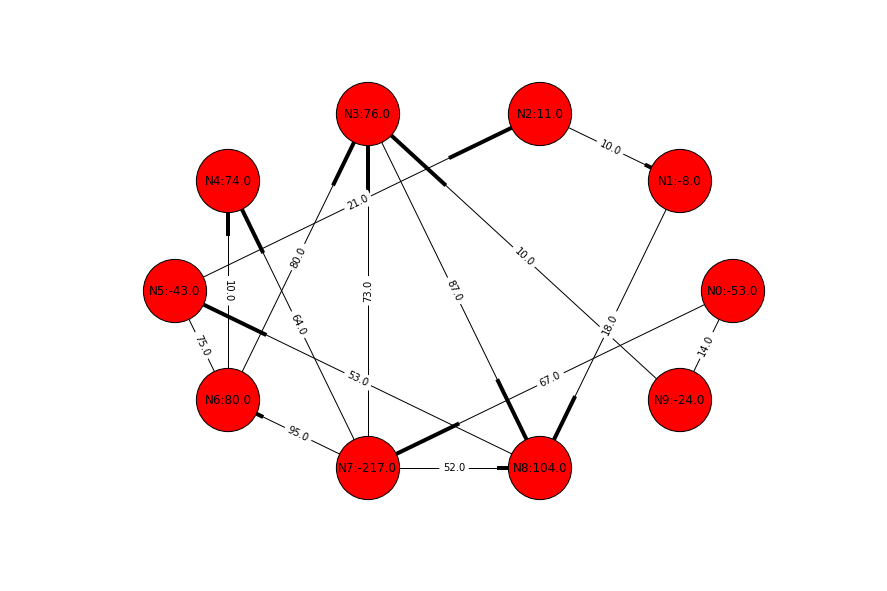

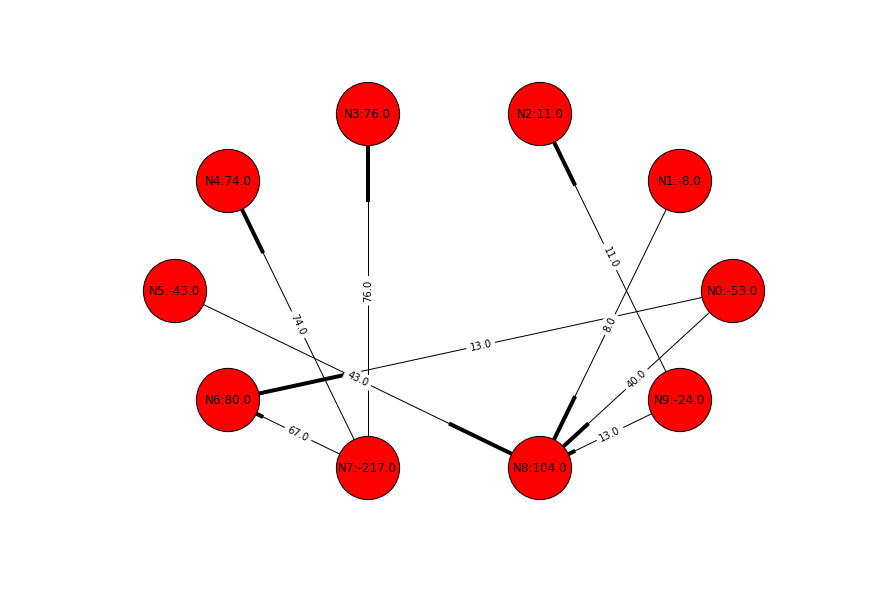

In [9]:
import cvxpy as cvx
import os

class UltraSolver():
    def solve(self, data):
        u = data.copy()
        people_number = data.shape[0]

        x = cvx.Variable(people_number, people_number)
        c = cvx.Variable(people_number, people_number)

        constraints = [cvx.sum_entries(c, axis = 1) == cvx.pos(u.sum(axis = 1) - u.sum(axis = 0).T),
                       cvx.sum_entries(c, axis = 0) == cvx.pos(u.sum(axis = 0) - u.sum(axis = 1).T),
                       c <= x,
                       c >= 0]

        obj = cvx.Minimize(cvx.sum_entries(x))

        prob = cvx.Problem(obj, constraints)
        prob.solve(solver = 'GUROBI')
        os.remove('./gurobi.log')
        
        return x.value

ultra_solver = UltraSolver()

people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)
G = nx.DiGraph(data)
G_solution = nx.DiGraph(ultra_solver.solve(data))
draw_graph(G)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

Solution is valid


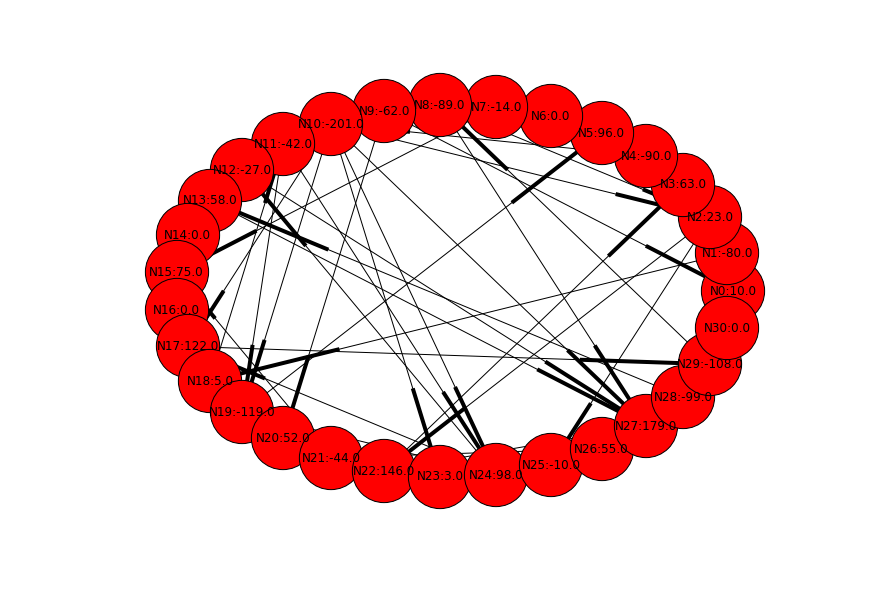

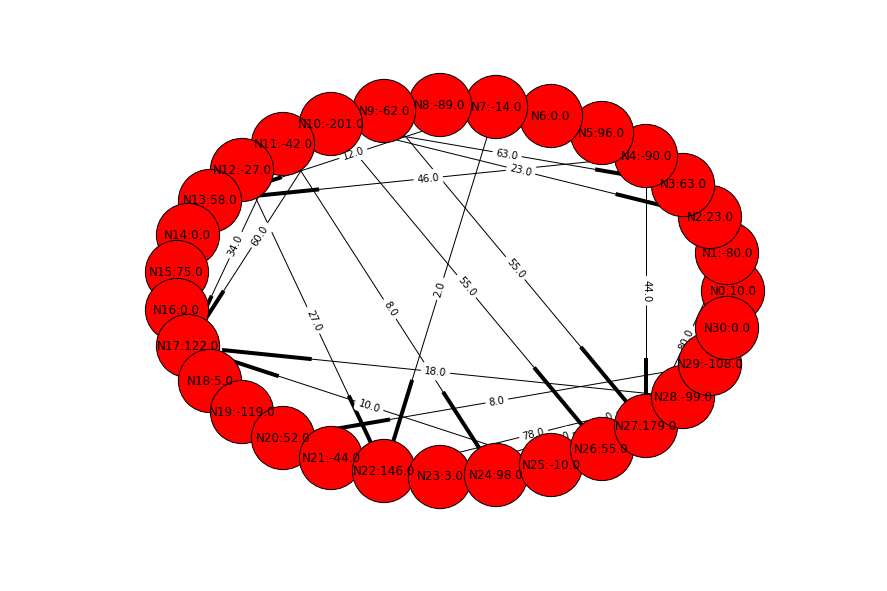

In [53]:
people_number = 31
data = generate_adj_matrix(people_number, 0.04, True)

G = nx.DiGraph(data)
G_solution = nx.DiGraph(ultra_solver.solve(data))

draw_graph(G, show_edges_labels = False)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

The maxium problem size that can be solved using this approach is 31 people graph. This is the restriction of GUROBI liscense for online courses that we used. (No more that 2000 variables). Also it is important to mention that this solution always has at most N - 1 edges, where N is the number of vertices. 

Let's try another formulation.
At first we want to kill all the cycles. The order matters and thus we want to solve the following problem:
* Kill cycles
* Not to create new relationships between nodes
* Reduce mutual debts

There is a property: given graph G, each node i of G has some input and some output verticies $V_{ji}$ and $V_{ij}$ respectively.

$b_i$ is the total balance of a node i is defined as follows: 
$$b_i =\sum_{j} V_{ji} - V_{ij}  $$

Here let's see what is the result of random cycle killing.

In [120]:
def remove_cycles_randomly(G_orig):
    G = G_orig.copy()
    
    while True:
        try:
            cycle = nx.find_cycle(G, orientation = 'ignore')

            min_edge_weight = np.inf
            edge_to_remove = None

            for v1, v2, direction in cycle:
                    weight = G.get_edge_data(v1, v2)['weight']

                    if weight < min_edge_weight:
                        min_edge_weight = weight
                        edge_to_remove = (v1, v2)

            for v1, v2, direction in cycle:
                old_edge_weight = G.get_edge_data(v1, v2)['weight']

                if direction == 'forward':
                    G.add_edge(v1, v2, weight = old_edge_weight - min_edge_weight)
                else:
                    G.add_edge(v1, v2, weight = old_edge_weight + min_edge_weight)

                if G.get_edge_data(v1, v2)['weight'] == 0:
                    G.remove_edge(v1, v2)

        except nx.NetworkXNoCycle:
            break
            
    return G

Solution is valid


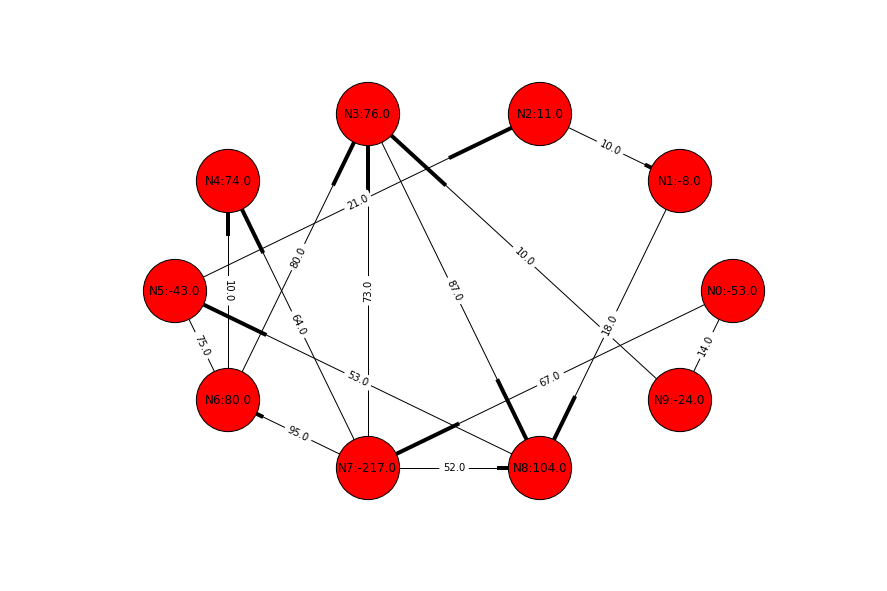

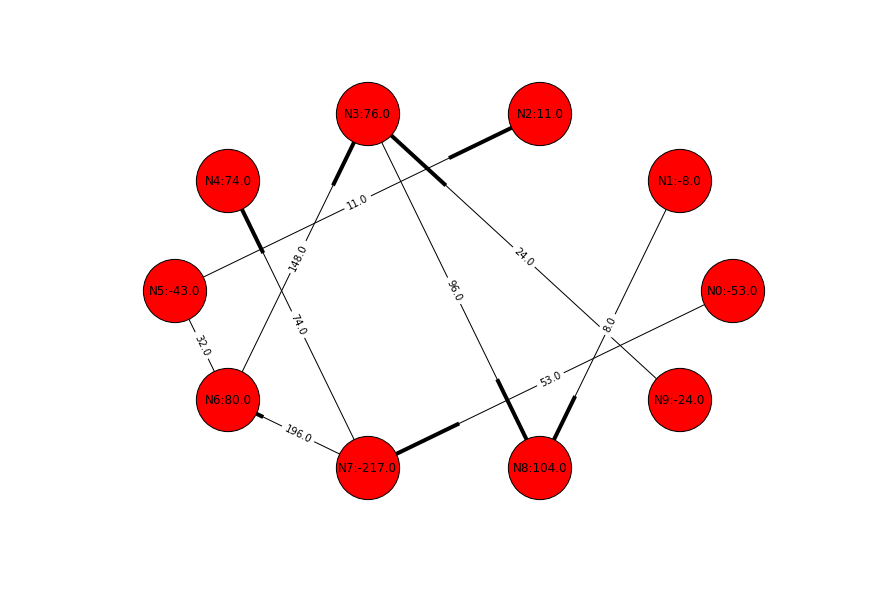

In [122]:
people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)

G = nx.DiGraph(data)
G_solution = remove_cycles_randomly(G)

draw_graph(G)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

We can see, that removing of cycles doesn't affect chains. But the most important property is that all the existing edges are not new, but were already existed. Now this graph is acyclic and thus it is a tree. Let's try to do smth with chains.

Solution is valid


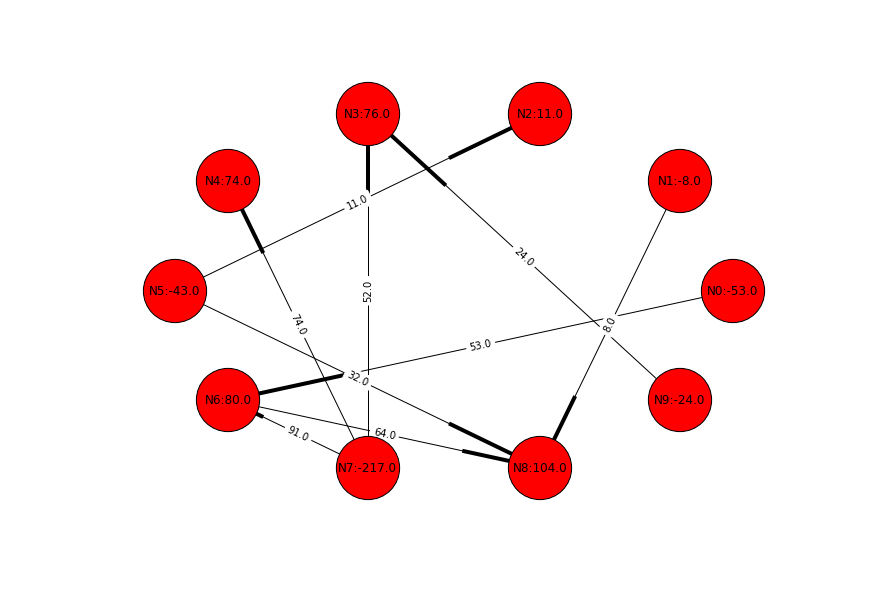

In [141]:
def kill_chains_randomly(G_orig):
    G = G_orig.copy()
    
    for node in G.nodes():
        out_edges = G.out_edges([node])
        in_edges = G.in_edges([node])

        while len(out_edges) > 0 and len(in_edges) > 0:
            in_edge = in_edges.pop()
            out_edge = out_edges.pop()

            in_weight = G.get_edge_data(in_edge[0], in_edge[1])['weight']
            out_weight = G.get_edge_data(out_edge[0], out_edge[1])['weight']

            if in_weight == out_weight:
                G.remove_edge(in_edge[0], node)
                G.remove_edge(node, out_edge[1])
                G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
            elif in_weight > out_weight:
                G.remove_edge(node, out_edge[1])
                G.add_edge(in_edge[0], out_edge[1], weight = out_weight)
                G.add_edge(in_edge[0], node, weight = in_weight - out_weight)
            elif in_weight < out_weight:
                G.remove_edge(in_edge[0], node)
                G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                G.add_edge(node, out_edge[1], weight = out_weight - in_weight)
        
    return G

random_chain_killed_graph = kill_chains_randomly(G_solution)
draw_graph(random_chain_killed_graph)

if check_solution(G, random_chain_killed_graph):
    print('Solution is valid')

Now let's combine this random strategy in one solver and then we will compare with it.

In [7]:
class RandomSolver():
    def remove_cycles_randomly(self, G_orig):
        G = G_orig.copy()

        while True:
            try:
                cycle = nx.find_cycle(G, orientation = 'ignore')

                min_edge_weight = np.inf
                edge_to_remove = None

                for v1, v2, direction in cycle:
                        weight = G.get_edge_data(v1, v2)['weight']

                        if weight < min_edge_weight:
                            min_edge_weight = weight
                            edge_to_remove = (v1, v2)

                for v1, v2, direction in cycle:
                    old_edge_weight = G.get_edge_data(v1, v2)['weight']

                    if direction == 'forward':
                        G.add_edge(v1, v2, weight = old_edge_weight - min_edge_weight)
                    else:
                        G.add_edge(v1, v2, weight = old_edge_weight + min_edge_weight)

                    if G.get_edge_data(v1, v2)['weight'] == 0:
                        G.remove_edge(v1, v2)

            except nx.NetworkXNoCycle:
                break

        return G
    
    def kill_chains_randomly(self, G_orig):
        G = G_orig.copy()

        for node in G.nodes():
            out_edges = G.out_edges([node])
            in_edges = G.in_edges([node])

            while len(out_edges) > 0 and len(in_edges) > 0:
                in_edge = in_edges.pop()
                out_edge = out_edges.pop()

                in_weight = G.get_edge_data(in_edge[0], in_edge[1])['weight']
                out_weight = G.get_edge_data(out_edge[0], out_edge[1])['weight']

                if in_weight == out_weight:
                    G.remove_edge(in_edge[0], node)
                    G.remove_edge(node, out_edge[1])
                    G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                elif in_weight > out_weight:
                    G.remove_edge(node, out_edge[1])
                    G.add_edge(in_edge[0], out_edge[1], weight = out_weight)
                    G.add_edge(in_edge[0], node, weight = in_weight - out_weight)
                elif in_weight < out_weight:
                    G.remove_edge(in_edge[0], node)
                    G.add_edge(in_edge[0], out_edge[1], weight = in_weight)
                    G.add_edge(node, out_edge[1], weight = out_weight - in_weight)

        return G

    def solve(self, data):
        return self.kill_chains_randomly(self.remove_cycles_randomly(nx.DiGraph(data)))

In [8]:
people_number = 100
data = generate_adj_matrix(people_number, 0.2, True)
random_solver = RandomSolver()

G = nx.DiGraph(data)
G_solution = random_solver.solve(data)

if check_solution(G, G_solution):
    print('Solution is valid')

Solution is valid


Now let's compare solutions of ultra_solver and random_solver

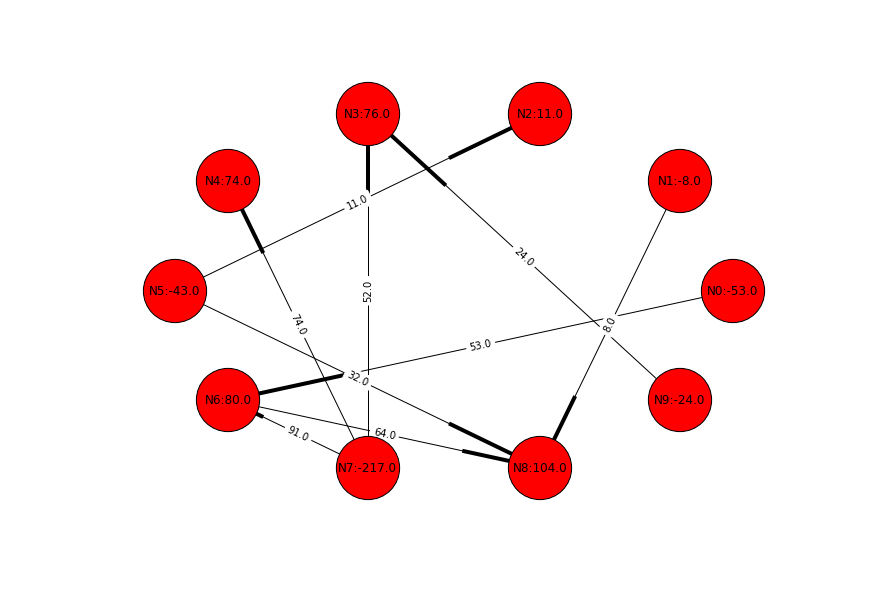

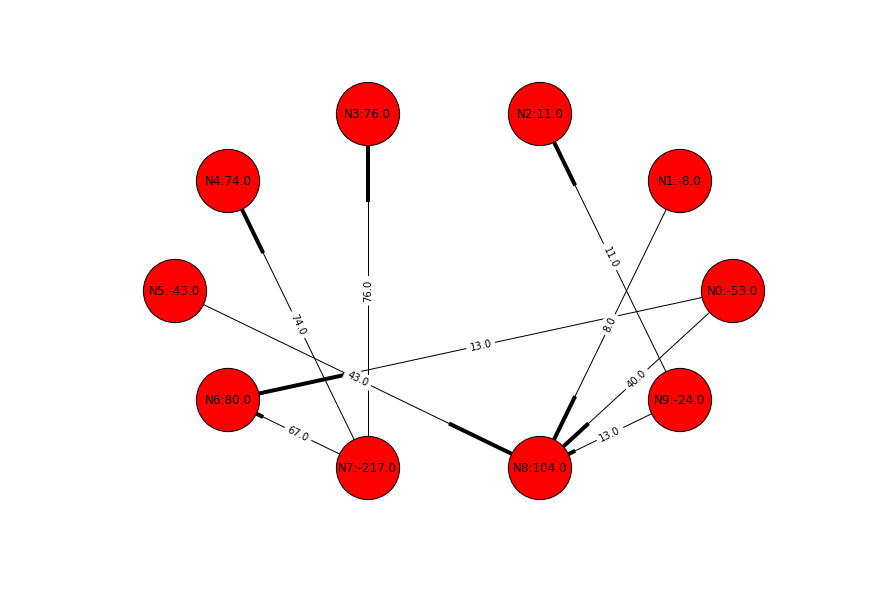

In [10]:
G_random = random_solver.solve(data)
G_ultra = nx.DiGraph(ultra_solver.solve(data))

draw_graph(G_random)
draw_graph(G_ultra)